In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, fftfreq
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns


In [ ]:
# Parámetros
Fs = 512  # Frecuencia de muestreo (Hz)
activities = ['baseline', 'pestañeo', 'musica_conocida', 'musica_desconocida', 
              'pestañeo2', 'redes_sociales', 'tecnicas_digitales', 'ojos_cerrados']

# 1. CARGAR Y VISUALIZAR LOS DATOS
# ================================

# Definir la carpeta donde están los archivos .dat
data_folder = 'marianela/marianela/'  

# Rutas de archivos para cada actividad
file_paths = {
    'baseline': data_folder + 'baseline.dat',
    'pestañeo': data_folder + 'pestaneos.dat',
    'musica_conocida': data_folder + 'musicaconocida.dat',
    'musica_desconocida': data_folder + 'musicanoconocida.dat',
    'ojos_cerrados': data_folder + 'ojoscerrados.dat',
    'redes_sociales': data_folder + 'leyendoredes.dat',
    'tecnicas_digitales': data_folder + 'leyendociencia.dat'
}
# Función para cargar cada archivo
def load_eeg_file(file_path):
    try:
        # Intentar cargar con formato estándar
        data = pd.read_csv(file_path, delimiter=' ', 
                          names=['timestamp', 'counter', 'eeg', 'attention', 'meditation', 'blinking'])
        return data['eeg'].values
    except:
        # Si falla, intentar detectar el formato
        with open(file_path, 'r') as file:
            first_line = file.readline().strip()
        
        # Determinar separador
        if ',' in first_line:
            sep = ','
        elif '\t' in first_line:
            sep = '\t'
        else:
            sep = ' '
        
        # Intentar varias configuraciones
        try:
            data = pd.read_csv(file_path, delimiter=sep, header=None)
            # Si hay múltiples columnas, asumimos que la tercera es EEG (índice 2)
            if data.shape[1] >= 3:
                return data.iloc[:, 2].values
            else:
                return data.iloc[:, 0].values
        except:
            print(f"Error al cargar {file_path}. Verificar formato.")
            return np.array([])

# Cargar cada archivo
segments = []
segment_labels = []

for activity, file_path in file_paths.items():
    eeg_data = load_eeg_file(file_path)
    if len(eeg_data) > 0:
        segments.append(eeg_data)
        segment_labels.append(activity)
        print(f"Cargado {activity}: {len(eeg_data)} muestras")

Cargado baseline: 30850 muestras
Cargado pestañeo: 30850 muestras
Cargado musica_conocida: 30850 muestras
Cargado musica_desconocida: 30830 muestras
Cargado ojos_cerrados: 30850 muestras
Cargado redes_sociales: 30830 muestras
Cargado tecnicas_digitales: 30850 muestras


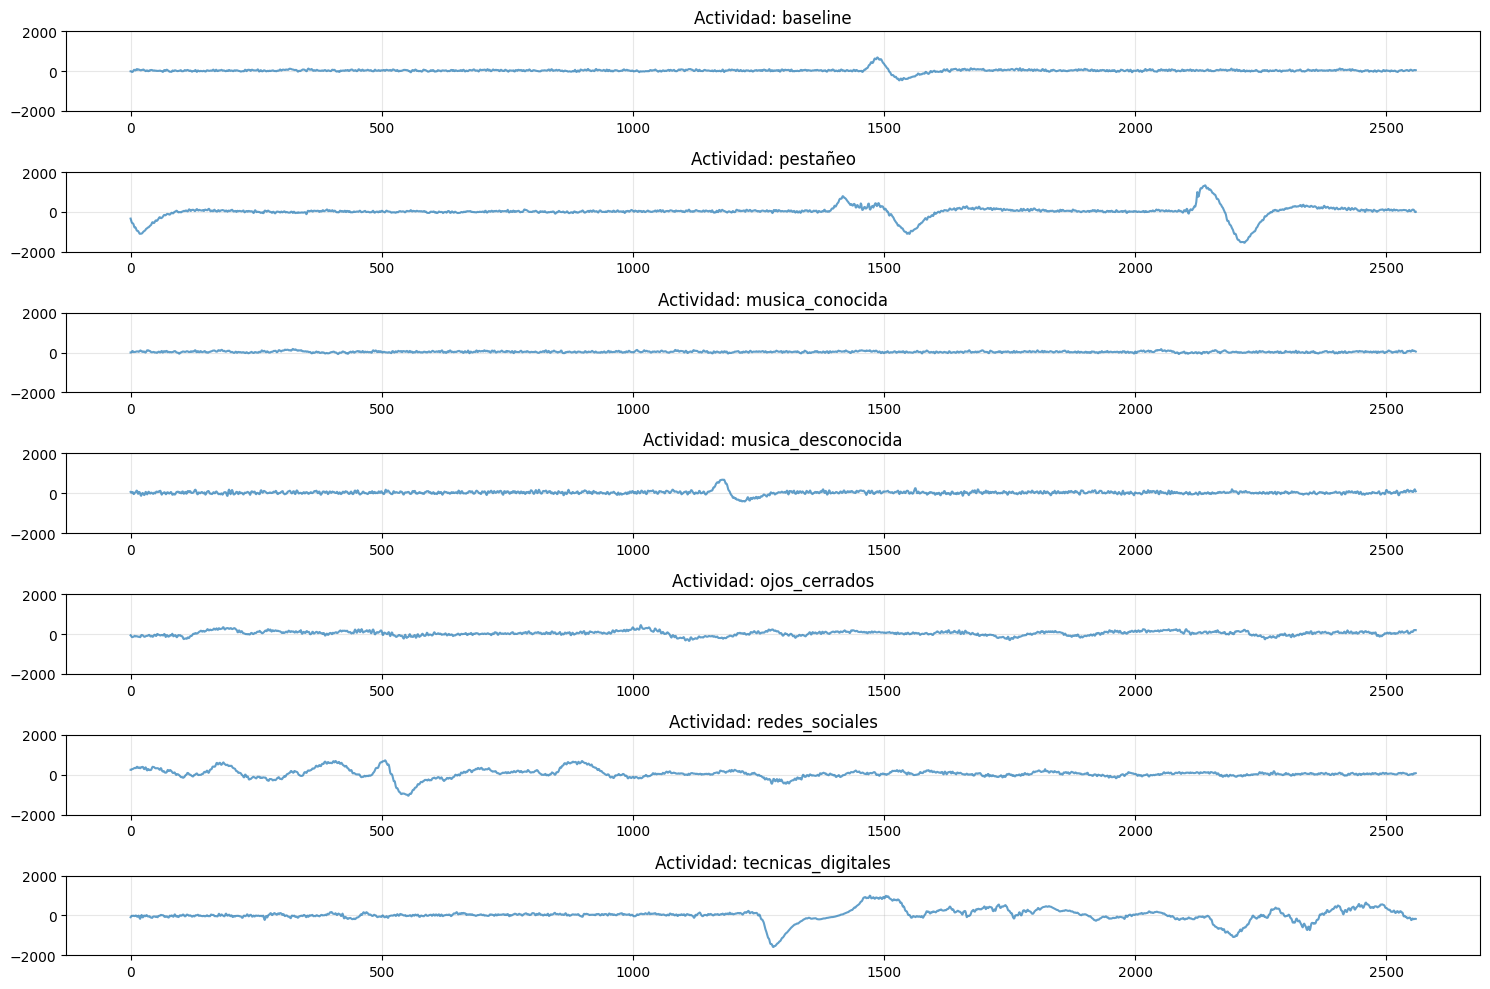

In [4]:
# Visualizar señales de cada archivo
plt.figure(figsize=(15, 10))
for i, (segment, label) in enumerate(zip(segments, segment_labels)):
    plt.subplot(len(segments), 1, i+1)
    plt.plot(segment[:int(5*Fs)], alpha=0.7)  # Mostrar primeros 5 segundos
    plt.title(f'Actividad: {label}')
    plt.ylim([-2000, 2000])
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

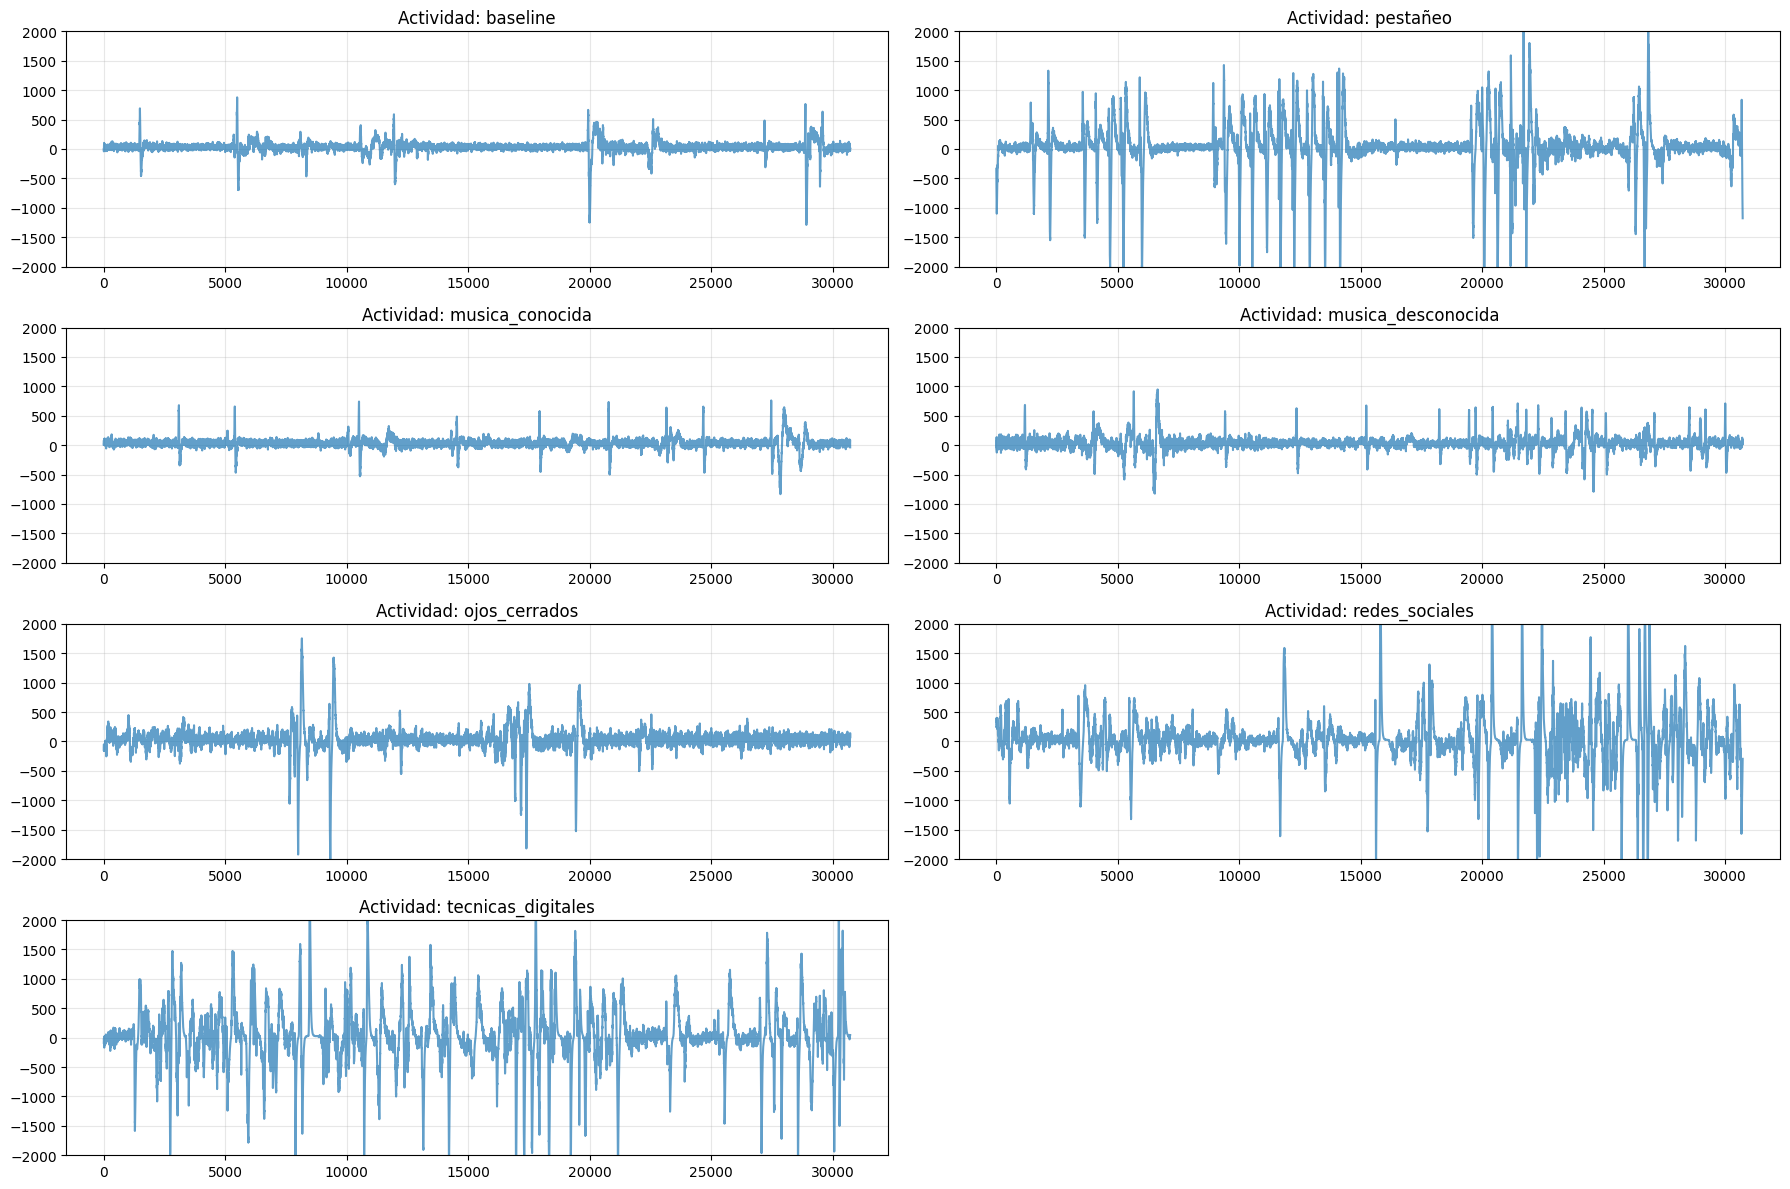

In [5]:
# Visualizar cada segmento
plt.figure(figsize=(18, 12))
for i, (segment, label) in enumerate(zip(segments, segment_labels)):
    plt.subplot(4, 2, i+1)
    plt.plot(segment[0:int(Fs*60)], alpha=0.7)  # Mostrar el primer minuto
    plt.title(f'Actividad: {label}')
    plt.ylim([-2000, 2000])
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

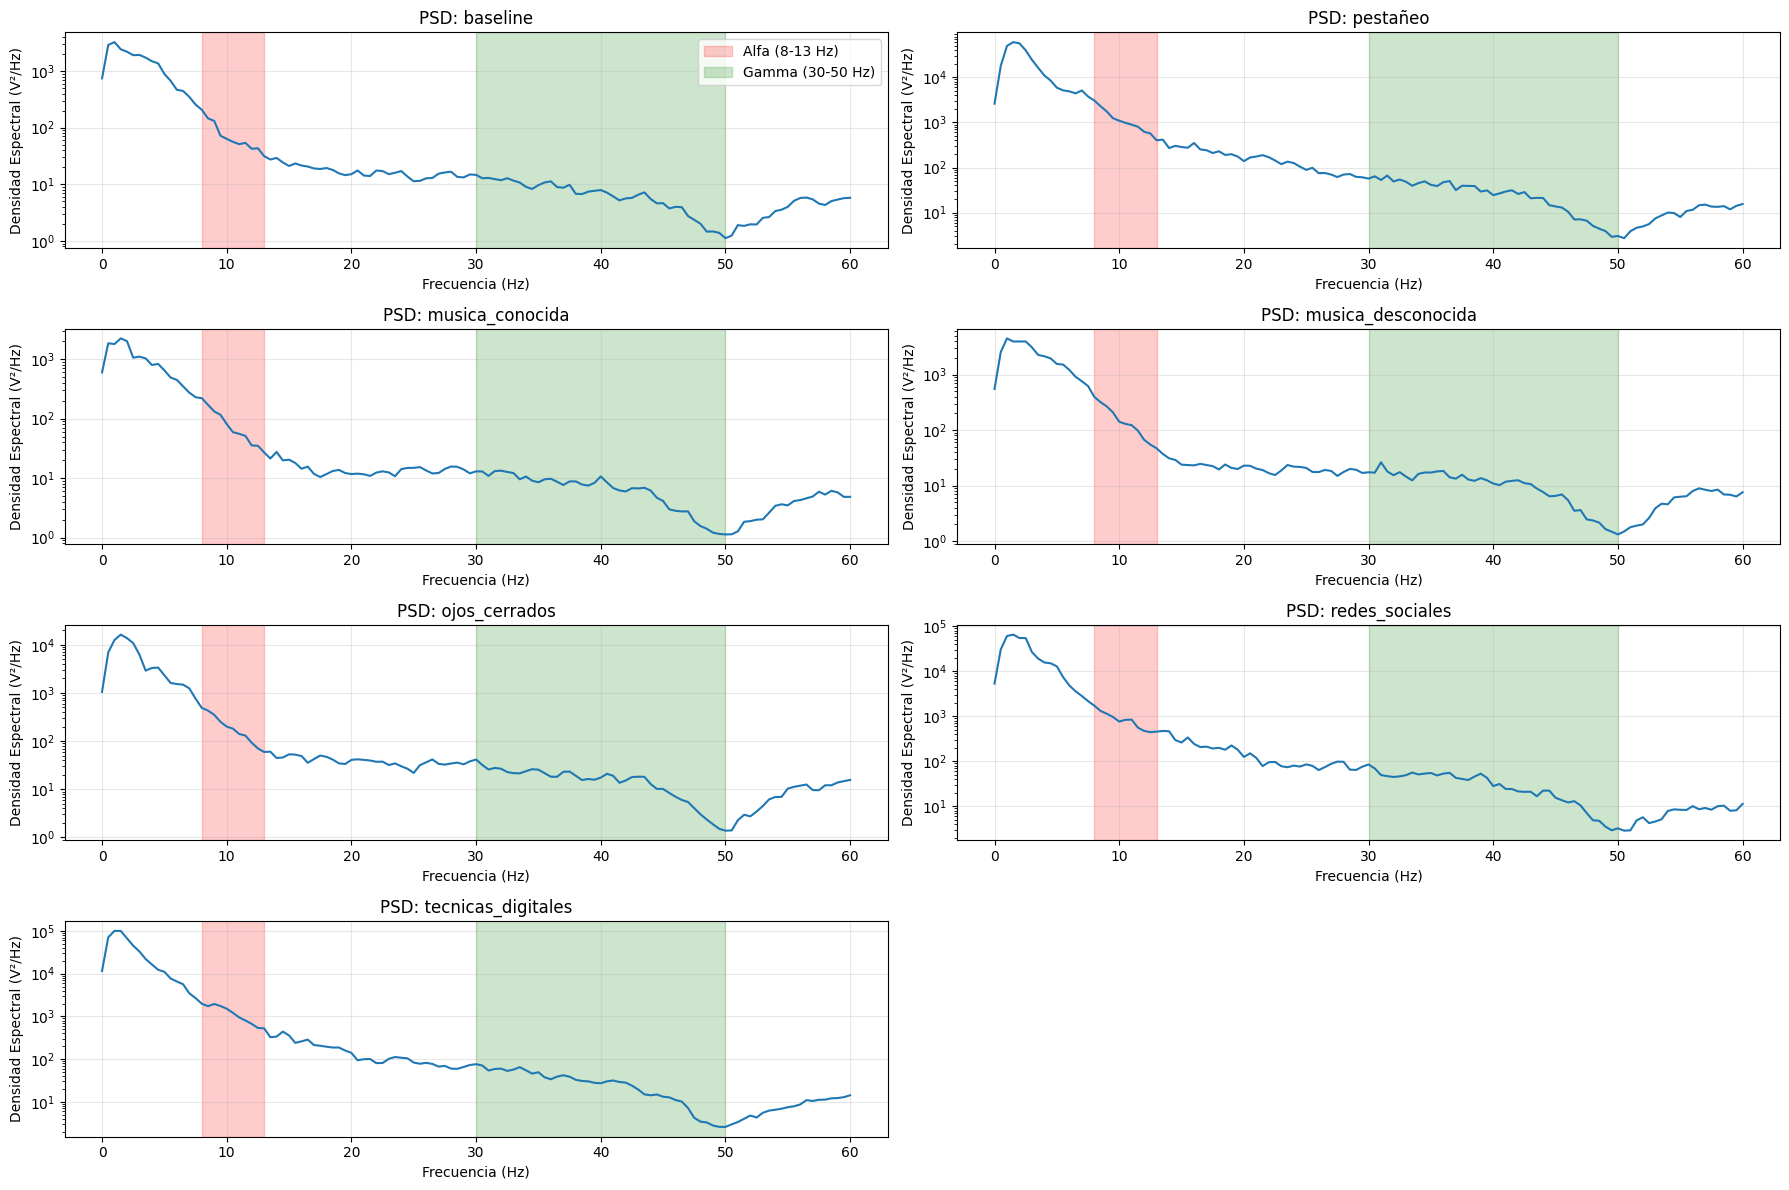

In [6]:
# 3. ANÁLISIS EN DOMINIO DE FRECUENCIA
# ===================================

# Analizar el espectro de frecuencia para cada actividad
plt.figure(figsize=(18, 12))
for i, (segment, label) in enumerate(zip(segments, segment_labels)):
    plt.subplot(4, 2, i+1)
    
    # Calcular PSD (Power Spectral Density)
    f, psd = signal.welch(segment, Fs, nperseg=1024)
    
    # Filtrar frecuencias hasta 60 Hz (las relevantes para EEG)
    mask = f <= 60
    f = f[mask]
    psd = psd[mask]
    
    plt.semilogy(f, psd)
    plt.title(f'PSD: {label}')
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Densidad Espectral (V²/Hz)')
    plt.grid(True, alpha=0.3)
    
    # Destacar bandas relevantes
    plt.axvspan(8, 13, color='r', alpha=0.2, label='Alfa (8-13 Hz)')
    plt.axvspan(30, 50, color='g', alpha=0.2, label='Gamma (30-50 Hz)')
    
    if i == 0:  # Solo añadir leyenda al primer gráfico
        plt.legend()
        
plt.tight_layout()
plt.show()

In [7]:
# 4. EXTRACCIÓN DE CARACTERÍSTICAS
# ===============================

# Definir tamaño de ventana para extracción de características
window_size = int(2 * Fs)  # 2 segundos de datos
step_size = int(0.5 * Fs)  # 0.5 segundos de solapamiento

def extract_features(window):
    """Extrae características de una ventana de señal EEG"""
    
    # Características temporales
    mean = np.mean(window)
    std = np.std(window)
    max_val = np.max(window)
    min_val = np.min(window)
    range_val = max_val - min_val
    
    # Detección de picos (útil para pestañeos)
    peaks, _ = signal.find_peaks(window, height=500, distance=int(0.5*Fs))
    peak_count = len(peaks)
    
    # Características frecuenciales
    f, psd = signal.welch(window, Fs, nperseg=512)
    
    # Potencia en bandas específicas
    delta_idx = np.logical_and(f >= 1, f < 4)
    theta_idx = np.logical_and(f >= 4, f < 8)
    alpha_idx = np.logical_and(f >= 8, f < 13)
    beta_idx = np.logical_and(f >= 13, f < 30)
    gamma_idx = np.logical_and(f >= 30, f < 60)
    
    delta_power = np.sum(psd[delta_idx])
    theta_power = np.sum(psd[theta_idx])
    alpha_power = np.sum(psd[alpha_idx])
    beta_power = np.sum(psd[beta_idx])
    gamma_power = np.sum(psd[gamma_idx])
    
    # Ratio alfa/beta (útil para relajación vs. concentración)
    alpha_beta_ratio = alpha_power / beta_power if beta_power > 0 else 0
    
    features = [mean, std, max_val, min_val, range_val, peak_count,
                delta_power, theta_power, alpha_power, beta_power, gamma_power,
                alpha_beta_ratio]
    
    feature_names = ['mean', 'std', 'max', 'min', 'range', 'peak_count',
                     'delta_power', 'theta_power', 'alpha_power', 'beta_power', 'gamma_power',
                     'alpha_beta_ratio']
    
    return features, feature_names

# Calcular características para cada segmento
X = []
y = []
window_indices = []  # Para seguimiento de qué ventana es de qué segmento

for segment_idx, (segment, label) in enumerate(zip(segments, segment_labels)):
    for i in range(0, len(segment) - window_size, step_size):
        window = segment[i:i+window_size]
        features, feature_names = extract_features(window)
        X.append(features)
        y.append(label)
        window_indices.append(segment_idx)

X = np.array(X)
y = np.array(y)

# Crear DataFrame para facilitar análisis
feature_df = pd.DataFrame(X, columns=feature_names)
feature_df['activity'] = y
feature_df['segment_idx'] = window_indices

print("Número de ventanas extraídas:", len(feature_df))
print("Distribución de actividades:")
print(feature_df['activity'].value_counts())

Número de ventanas extraídas: 819
Distribución de actividades:
activity
baseline              117
pestañeo              117
musica_conocida       117
musica_desconocida    117
ojos_cerrados         117
redes_sociales        117
tecnicas_digitales    117
Name: count, dtype: int64


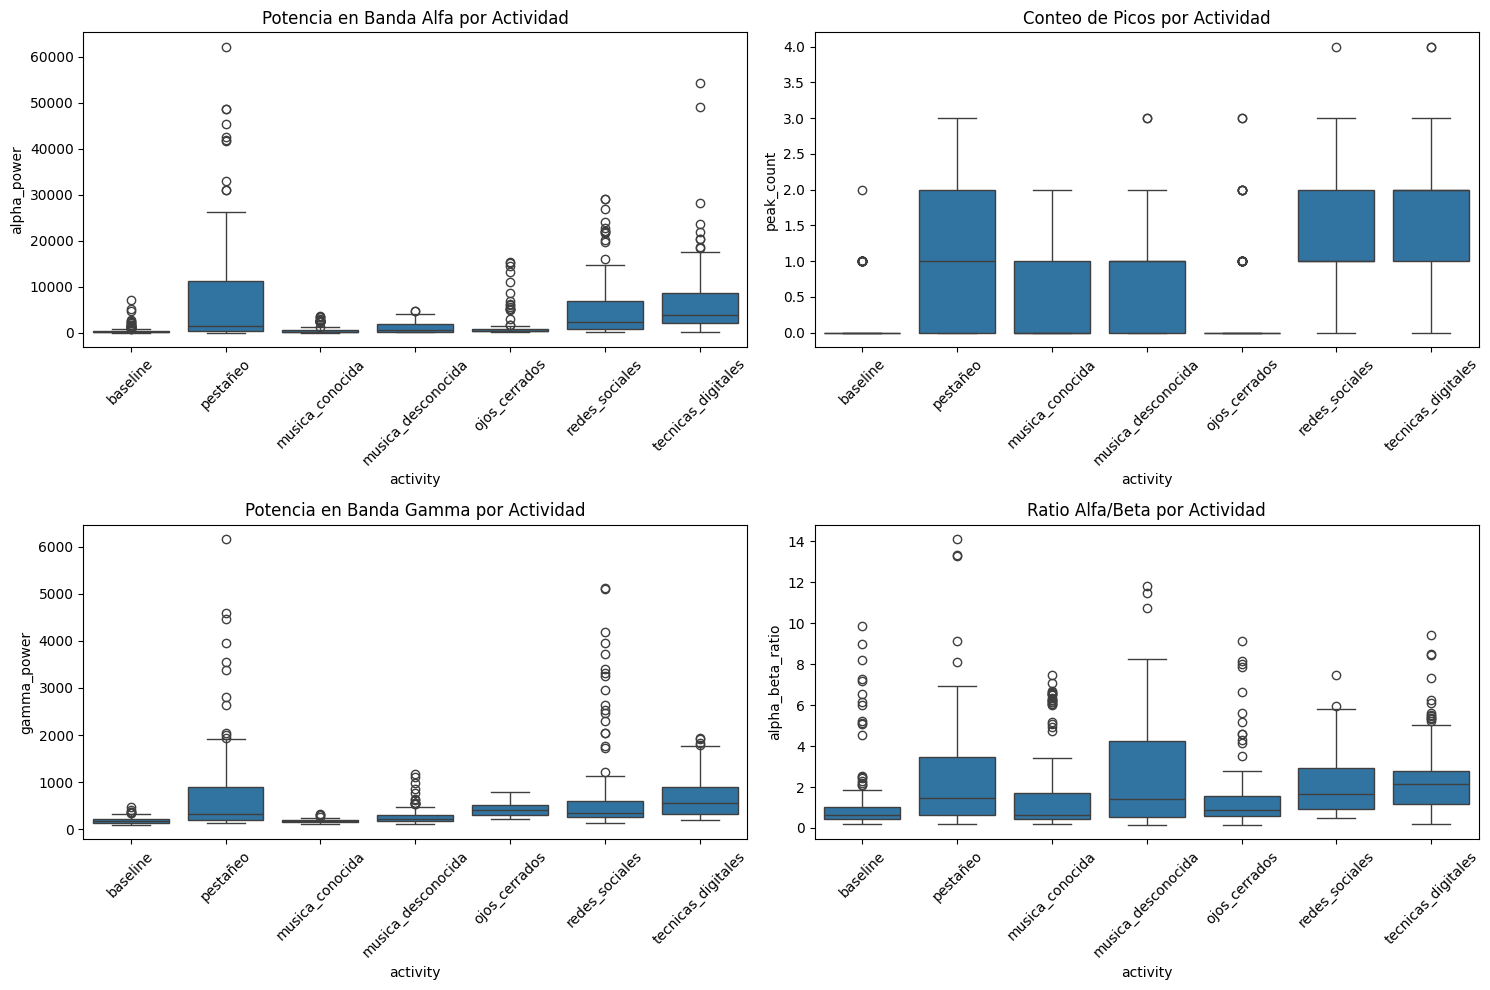

In [8]:
# 5. VISUALIZACIÓN DE CARACTERÍSTICAS
# =================================

# Visualizar características clave para cada actividad
plt.figure(figsize=(15, 10))

# Potencia en banda Alfa (importante para ojos cerrados)
plt.subplot(2, 2, 1)
sns.boxplot(x='activity', y='alpha_power', data=feature_df)
plt.title('Potencia en Banda Alfa por Actividad')
plt.xticks(rotation=45)
plt.tight_layout()

# Conteo de picos (importante para pestañeo)
plt.subplot(2, 2, 2)
sns.boxplot(x='activity', y='peak_count', data=feature_df)
plt.title('Conteo de Picos por Actividad')
plt.xticks(rotation=45)
plt.tight_layout()

# Potencia en banda Gamma (importante para concentración, lectura)
plt.subplot(2, 2, 3)
sns.boxplot(x='activity', y='gamma_power', data=feature_df)
plt.title('Potencia en Banda Gamma por Actividad')
plt.xticks(rotation=45)
plt.tight_layout()

# Ratio Alfa/Beta (relajación vs. concentración)
plt.subplot(2, 2, 4)
sns.boxplot(x='activity', y='alpha_beta_ratio', data=feature_df)
plt.title('Ratio Alfa/Beta por Actividad')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


Dimensionalidad reducida de 12 a 6 características
Precisión del modelo: 0.5407


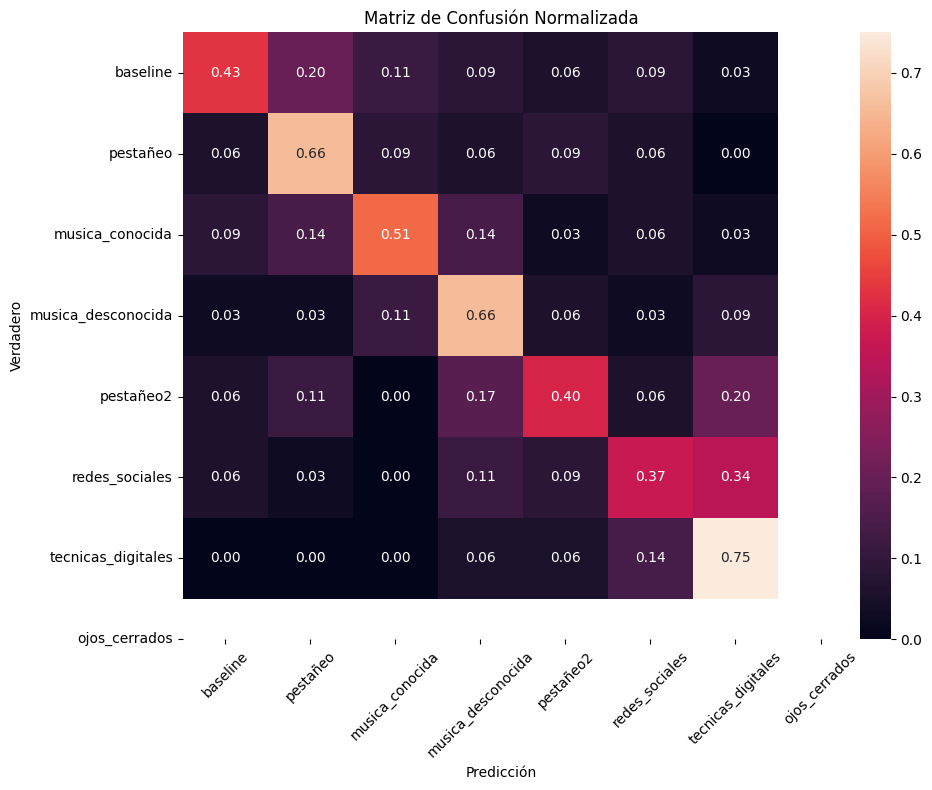

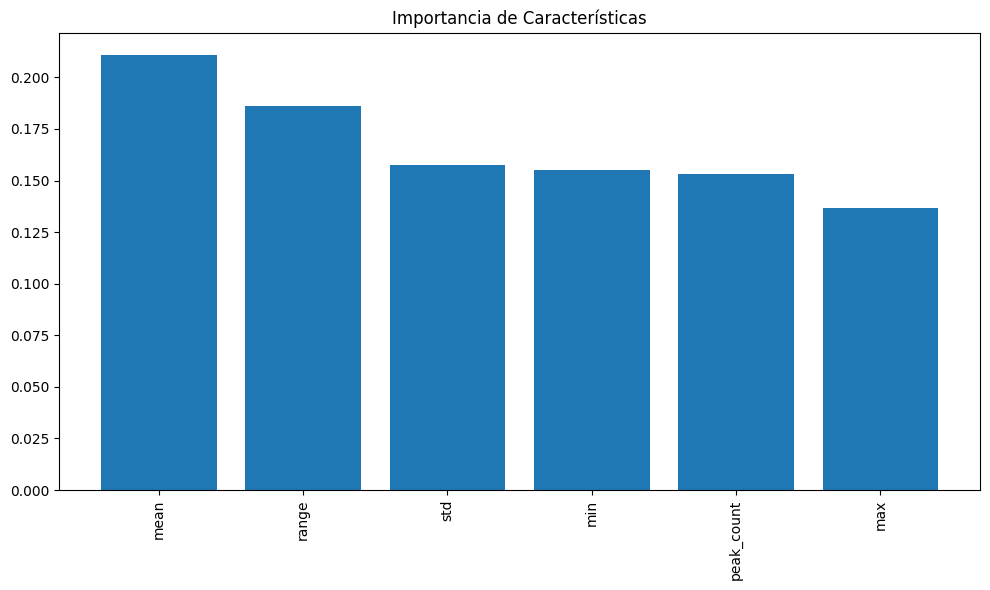

In [9]:
# 6. CLASIFICACIÓN
# ===============

# Normalizar características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Opcional: Reducción de dimensionalidad
pca = PCA(n_components=0.95)  # Conservar 95% de la varianza
X_pca = pca.fit_transform(X_scaled)

print(f"Dimensionalidad reducida de {X_scaled.shape[1]} a {X_pca.shape[1]} características")

# División en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.3, random_state=42, stratify=y
)

# Entrenar clasificador
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predecir y evaluar
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy:.4f}")

# Matriz de confusión
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=activities, yticklabels=activities)
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión Normalizada')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Importancia de características
if X_scaled.shape[1] == len(feature_names):  # Si no usamos PCA
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.title('Importancia de Características')
    plt.bar(range(len(indices)), importances[indices], align='center')
    plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

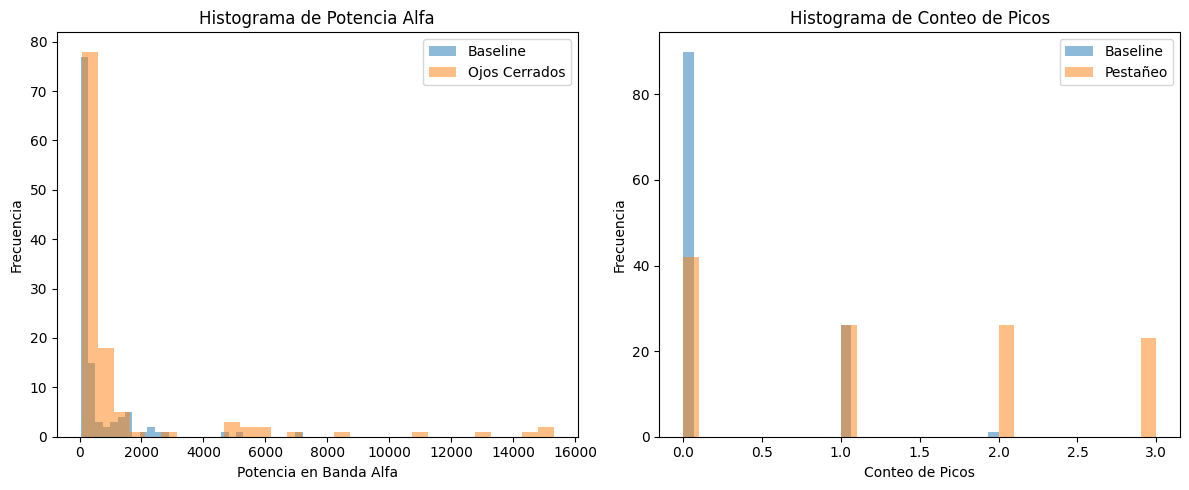

In [10]:
# 7. ANÁLISIS ESPECÍFICO POR ACTIVIDAD
# ==================================

# Análisis para ojos cerrados vs baseline (banda alfa)
ojos_cerrados_df = feature_df[feature_df['activity'] == 'ojos_cerrados']
baseline_df = feature_df[feature_df['activity'] == 'baseline']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(baseline_df['alpha_power'], bins=30, alpha=0.5, label='Baseline')
plt.hist(ojos_cerrados_df['alpha_power'], bins=30, alpha=0.5, label='Ojos Cerrados')
plt.xlabel('Potencia en Banda Alfa')
plt.ylabel('Frecuencia')
plt.title('Histograma de Potencia Alfa')
plt.legend()

# Análisis para pestañeo vs baseline (conteo de picos)
pestañeo_df = pd.concat([
    feature_df[feature_df['activity'] == 'pestañeo'],
    feature_df[feature_df['activity'] == 'pestañeo2']
])

plt.subplot(1, 2, 2)
plt.hist(baseline_df['peak_count'], bins=30, alpha=0.5, label='Baseline')
plt.hist(pestañeo_df['peak_count'], bins=30, alpha=0.5, label='Pestañeo')
plt.xlabel('Conteo de Picos')
plt.ylabel('Frecuencia')
plt.title('Histograma de Conteo de Picos')
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
# 8. CONCLUSIONES
# =============

# Aquí deberías incluir tus conclusiones basadas en los resultados obtenidos
# Recuerda identificar qué características son más útiles para distinguir cada actividad
# y cómo se comporta el clasificador en general.

print("\nCONCLUSIONES:")
print("=============")
print("1. Las actividades que mejor se pueden distinguir son: ...")
print("2. Las características más importantes para cada actividad son: ...")
print("3. La precisión general del clasificador es: {:.2f}%".format(accuracy * 100))


CONCLUSIONES:
1. Las actividades que mejor se pueden distinguir son: ...
2. Las características más importantes para cada actividad son: ...
3. La precisión general del clasificador es: 54.07%
